In [4]:
import torch
import numpy as np
from torch import nn

In [7]:
# Criação do modelo
class LineNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(1, 1)
    )

  # Como a rede computa
  def forward(self, x):
    return self.layers(x)

### Preparando a infraestrutura de dados

In [8]:
from torch.utils.data import Dataset, DataLoader
import torch.distributions.uniform as urand

In [9]:
# Criação do dataset
class AlgebraicDataset(Dataset):
  def __init__(self, function, interval, nsamples):
    X = urand.Uniform(interval[0], interval[1]).sample([nsamples])
    self.data = [(x, function(x)) for x in X]

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

In [10]:
line = lambda x: 2*x + 3
interval = (-10, 10)
train_nsamples = 1000
test_nsamples = 100

In [11]:
train_dataset = AlgebraicDataset(line, interval, train_nsamples)
test_dataset = AlgebraicDataset(line, interval, test_nsamples)

# Entrega os dados de pouco em pouco (utilizado quando o conjunto de dados é grande)
train_dataloader = DataLoader(train_dataset, batch_size=train_nsamples, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size= test_nsamples, shuffle=True)

### Hiperparâmetros de Otimização

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Rodando na {device}')

Rodando na cpu


In [13]:
model = LineNetwork().to(device)

In [14]:
# Função de perda (loss function)
# Erro quadrático médio (Mean Squared Error)
lossfunc = nn.MSELoss()
# Gradiente Descendente Estocástico
# SGB = Stochastic Gradient Descent
optmizer = torch.optim.SGD(model.parameters(), lr=0.001)
# taxa de aprendizado lr = learning rate

In [15]:
def train(model, dataloader, lossfunc, optmizer):
  model.train()
  cumloss = 0.0
  # unsqueeze = modificação do agrupamento dos dados [[1], [2], [3]...]
  for X, y in dataloader:
    X = X.unsqueeze(1).float().to(device)
    y = y.unsqueeze(1).float().to(device)

    pred = model(X)
    loss = lossfunc(pred, y)

    # zera os gradientes acumulados
    optmizer.zero_grad()
    # computa os gradientes
    loss.backward()
    # anda, de fato, na direção que reduz o erro local
    optmizer.step()

    # loss é um tensor; item para obter o float
    cumloss += loss.item()

    return cumloss / len(dataloader)


def test(model, dataloader, lossfunc):
  model.eval()

  cumloss = 0.0
  with torch.no_grad():
    # unsqueeze = modificação do agrupamento dos dados [[1], [2], [3]...]
    for X, y in dataloader:
      X = X.unsqueeze(1).float().to(device)
      y = y.unsqueeze(1).float().to(device)

      pred = model(X)
      loss = lossfunc(pred, y)
      cumloss += loss.item()

    return cumloss / len(dataloader)

### Treinando a rede


In [2]:
import matplotlib.pyplot as plt

In [16]:
# Para visualizar
def plot_comparinson(f, model, interval=(-10, 10), nsamples=10):
  fig, ax = plt.subplots(figsize=(10, 10))

  ax.grid(True, which='both')
  ax.spines['left'].set_position('zero')
  ax.spines['right'].set_color('none')
  ax.spines['bottom'].set_position('zero')
  ax.spines['top'].set_color('none')

  samples = np.linspace(interval[0], interval[1], nsamples)
  model.eval()
  with torch.no_grad():
    pred = model(torch.tensor(samples).unsqueeze(1).float().to(device))

  ax.plot(samples, list(map(f, samples)), "o", label="ground truth")
  ax.plot(samples, pred.cpu(), label="model")
  plt.legend()
  plt.show()


Epoch: 0; Train Loss: 5.5372514724731445


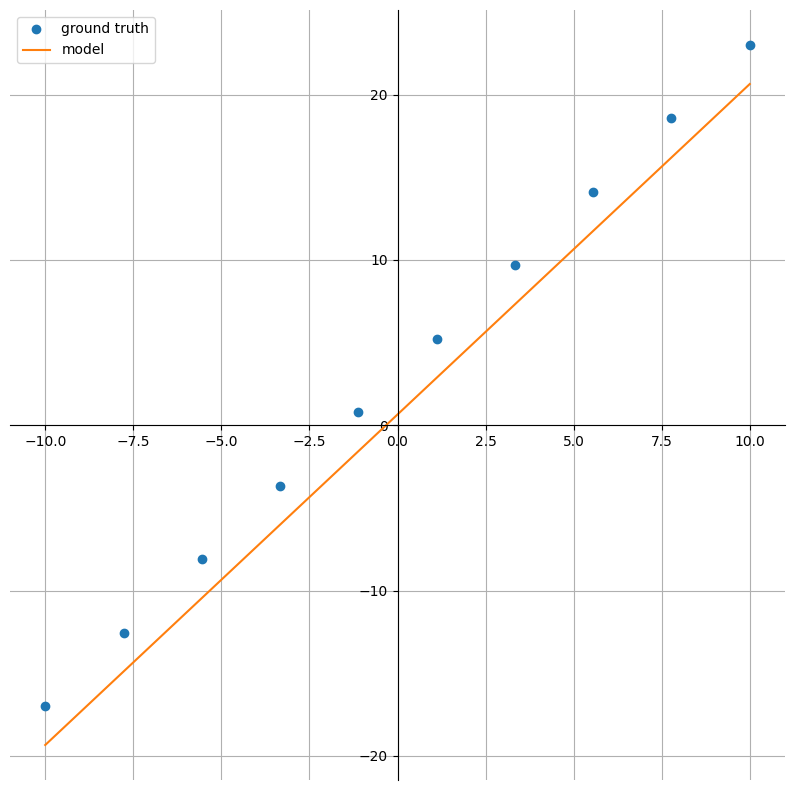

Epoch: 10; Train Loss: 5.319921970367432


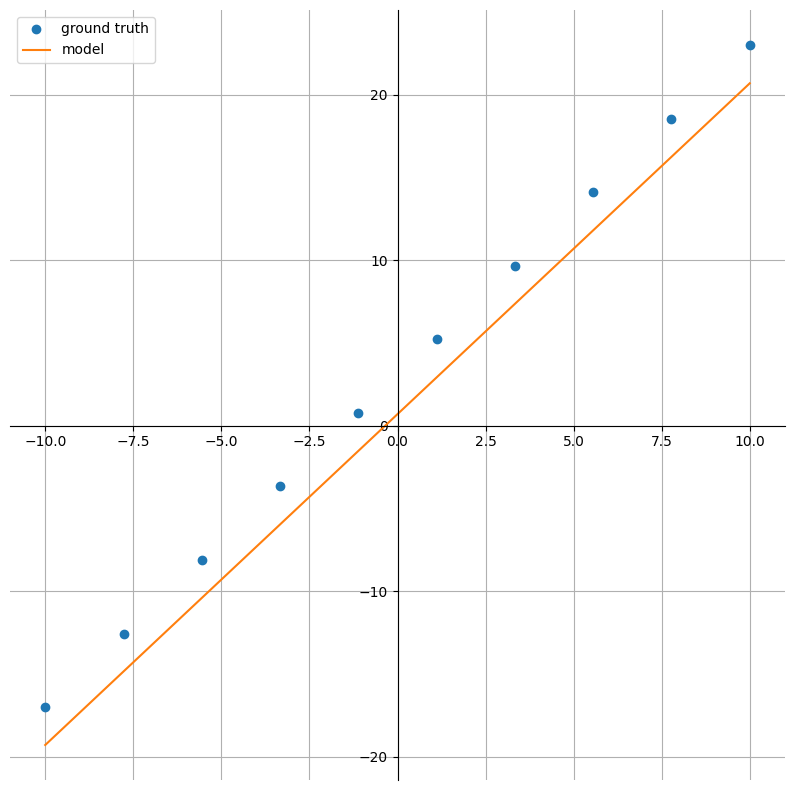

Epoch: 20; Train Loss: 5.111120223999023


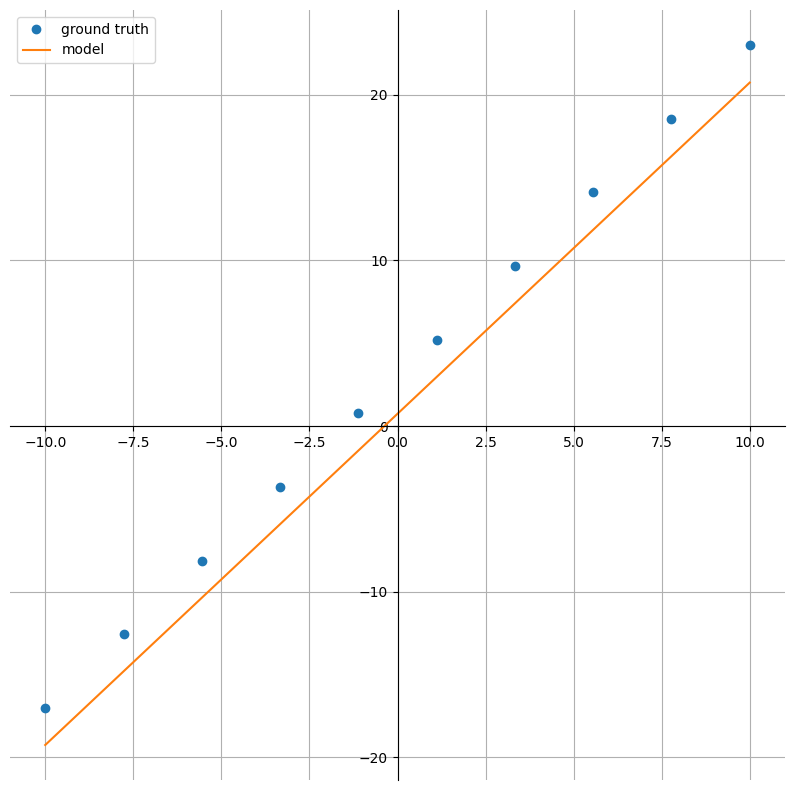

Epoch: 30; Train Loss: 4.910514831542969


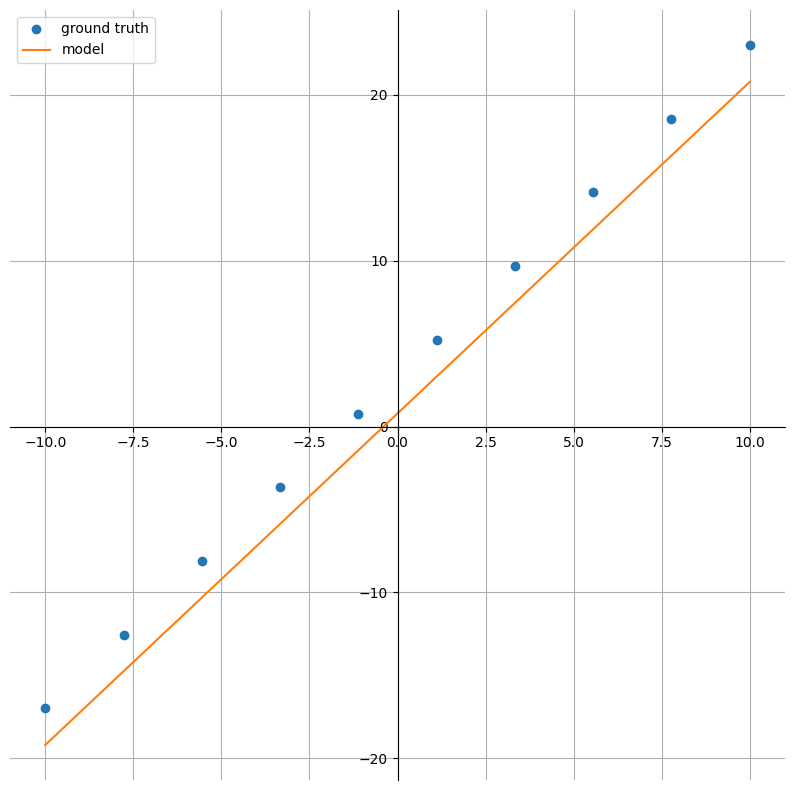

Epoch: 40; Train Loss: 4.717782497406006


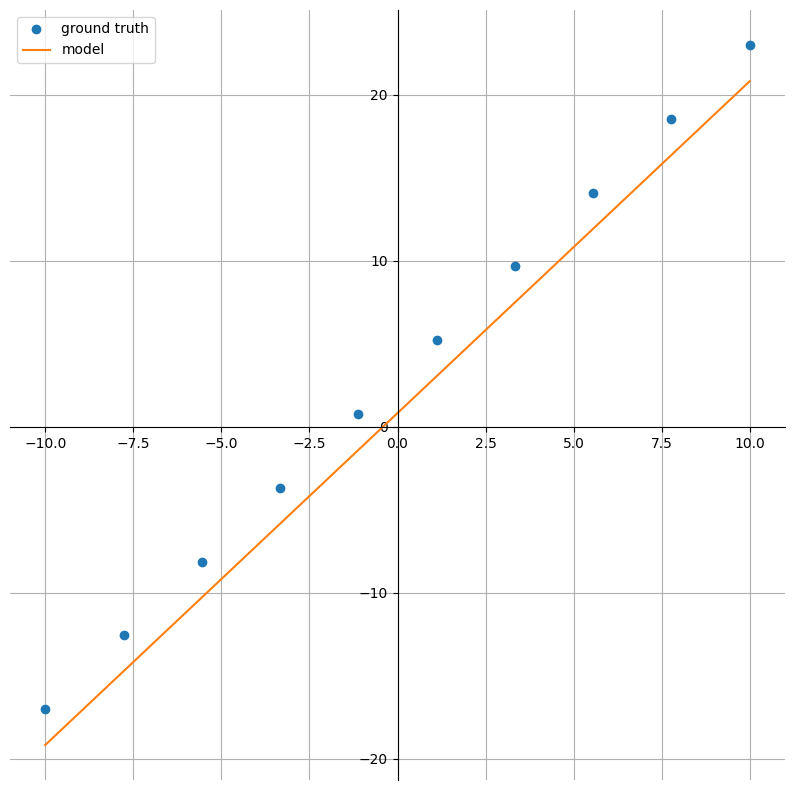

Epoch: 50; Train Loss: 4.53261661529541


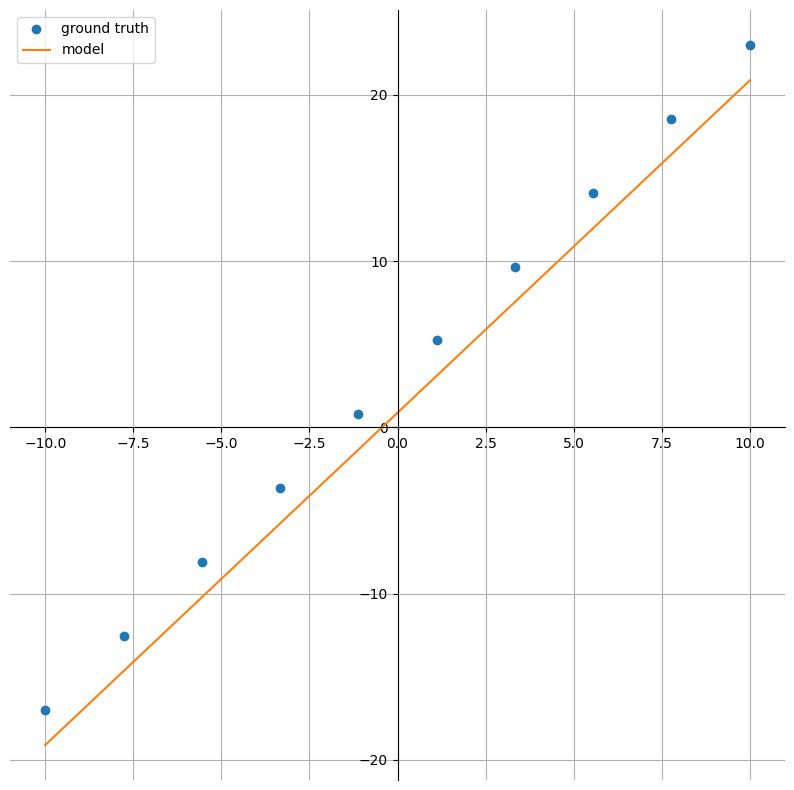

Epoch: 60; Train Loss: 4.354716777801514


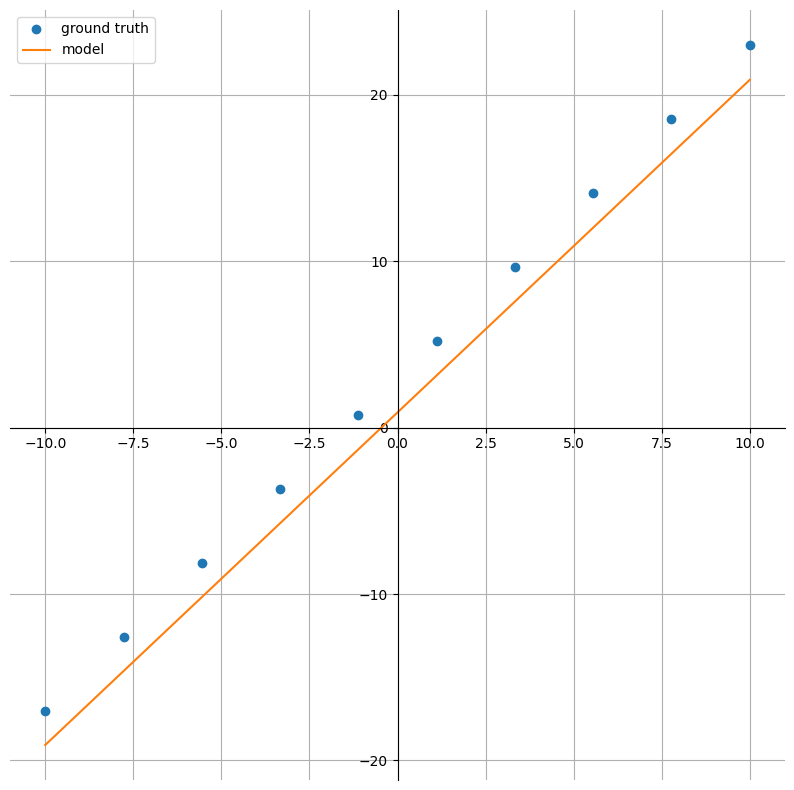

Epoch: 70; Train Loss: 4.1837992668151855


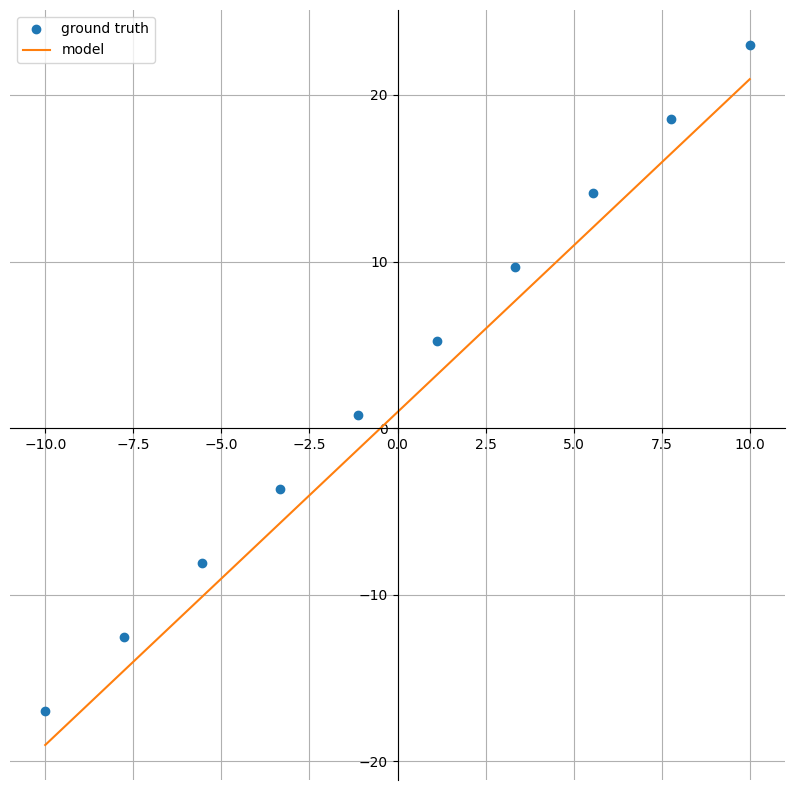

Epoch: 80; Train Loss: 4.019589424133301


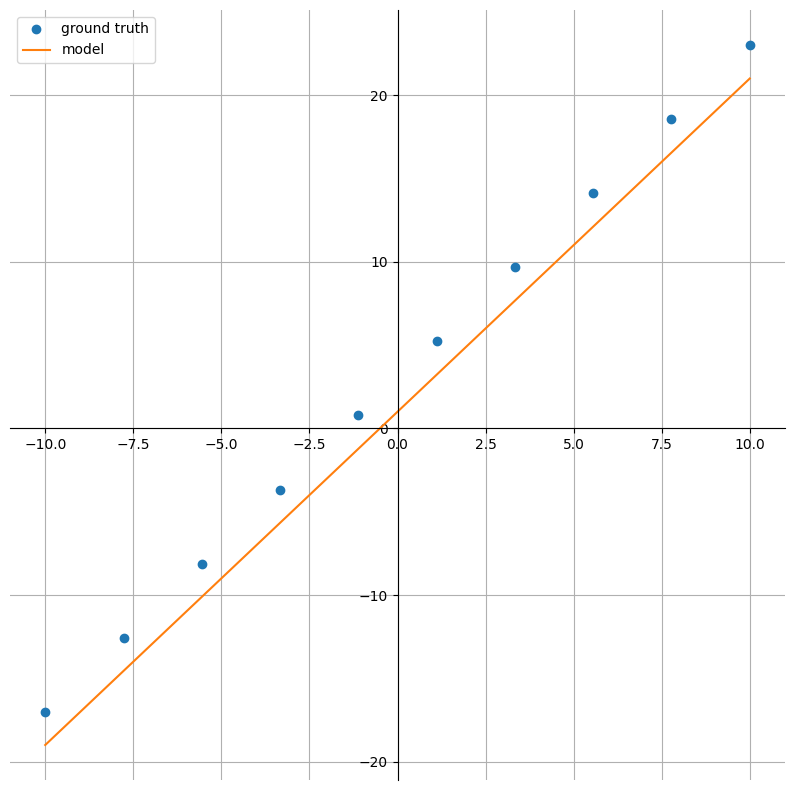

Epoch: 90; Train Loss: 3.861825704574585


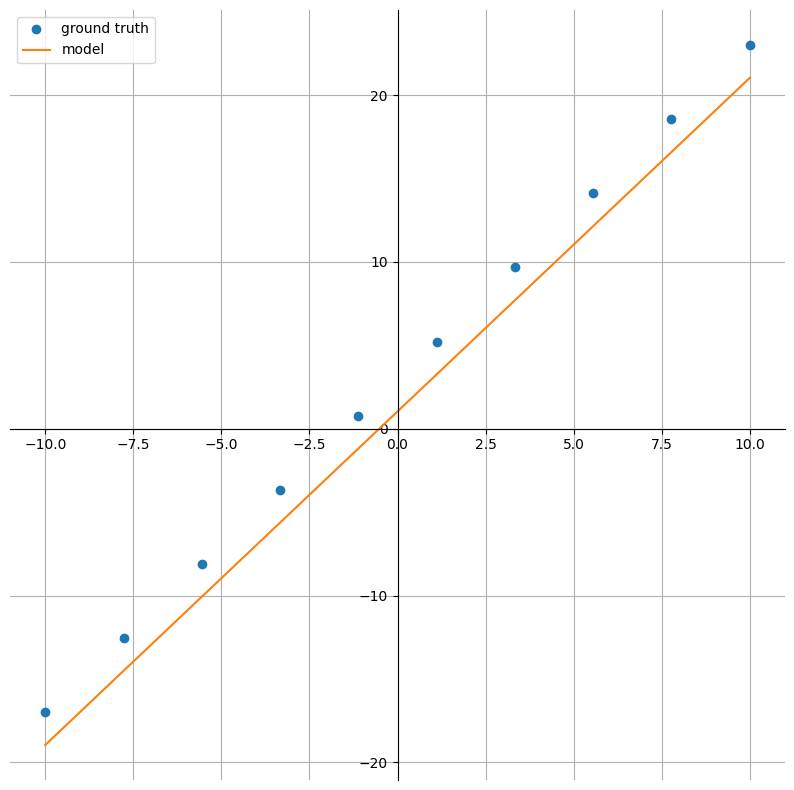

Epoch: 100; Train Loss: 3.7102537155151367


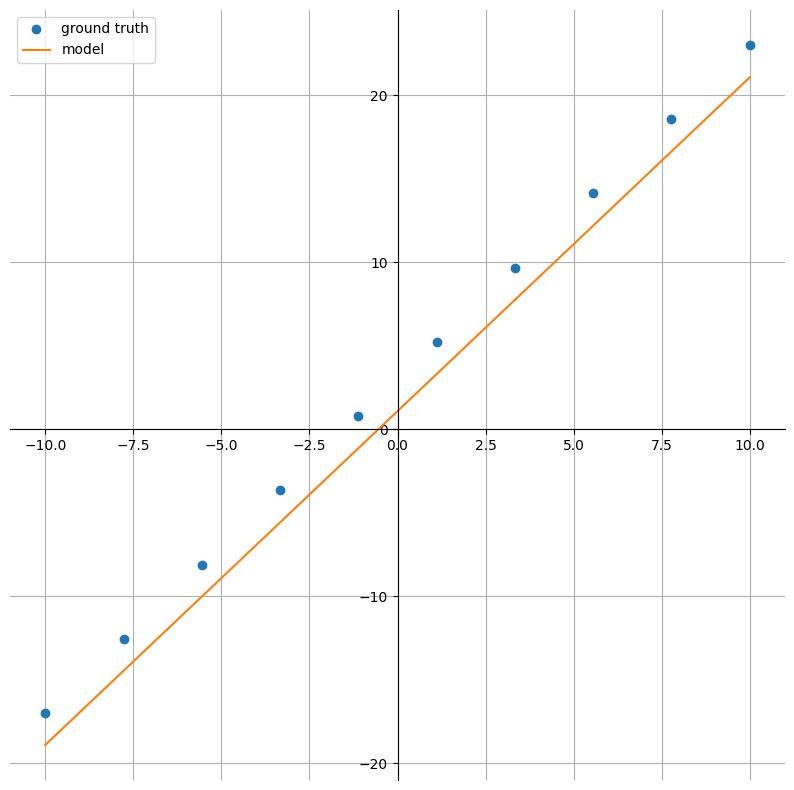

Epoch: 110; Train Loss: 3.5646302700042725


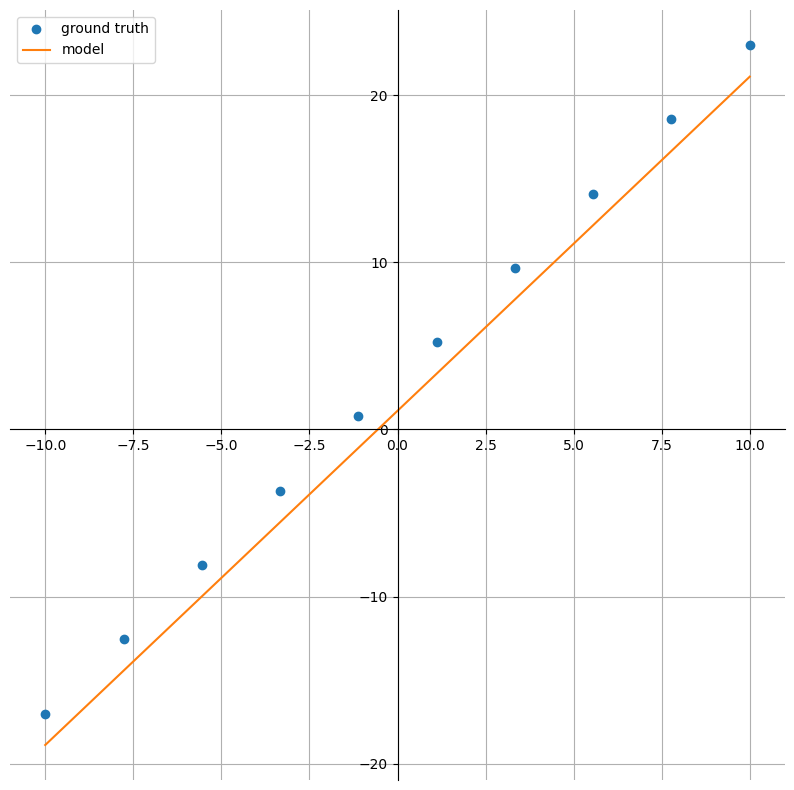

Epoch: 120; Train Loss: 3.4247233867645264


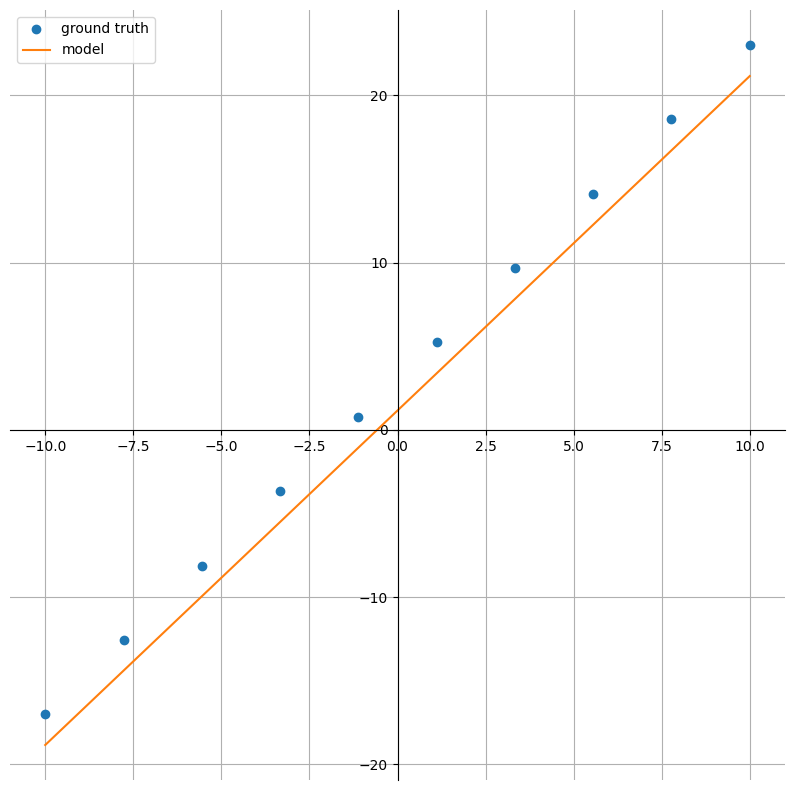

Epoch: 130; Train Loss: 3.2903072834014893


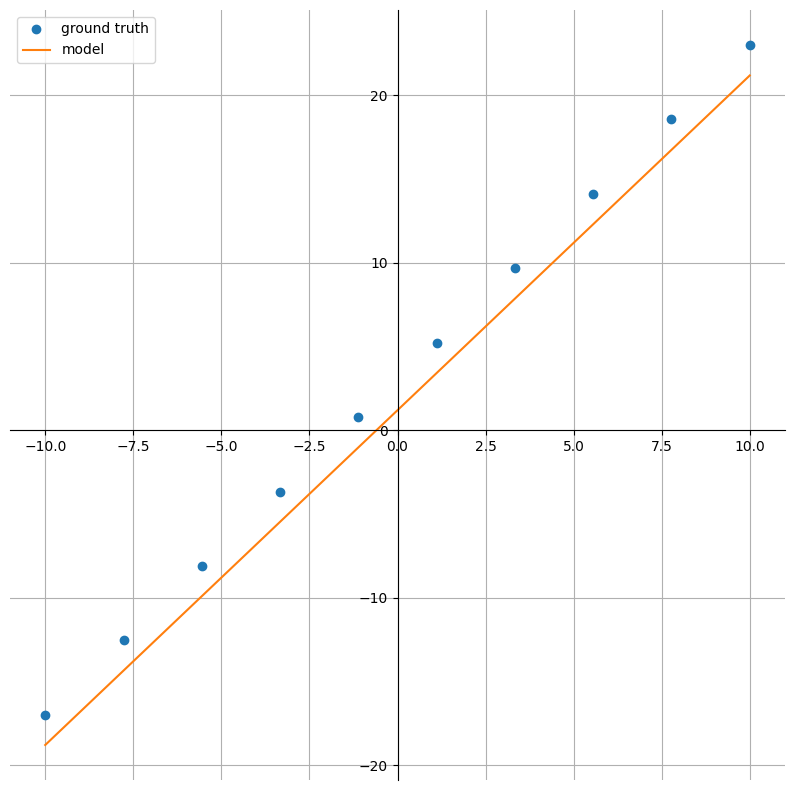

Epoch: 140; Train Loss: 3.1611669063568115


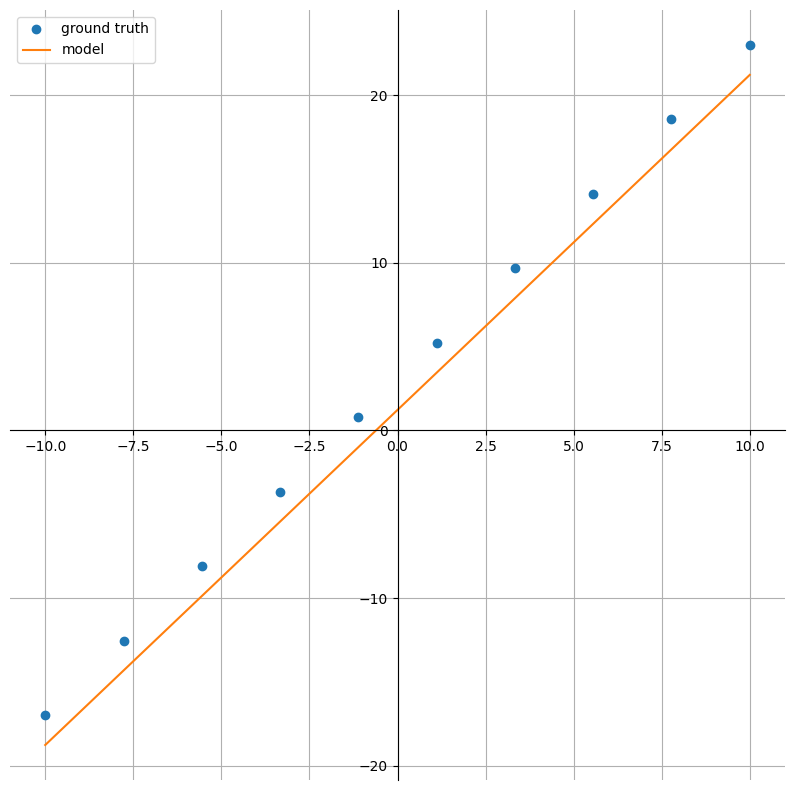

Epoch: 150; Train Loss: 3.0370945930480957


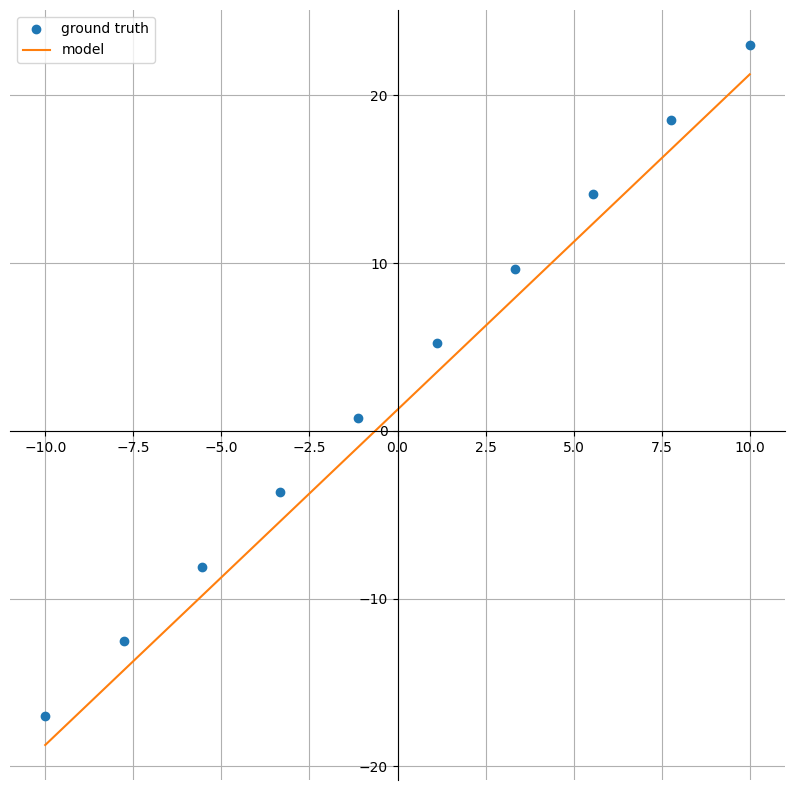

Epoch: 160; Train Loss: 2.9178919792175293


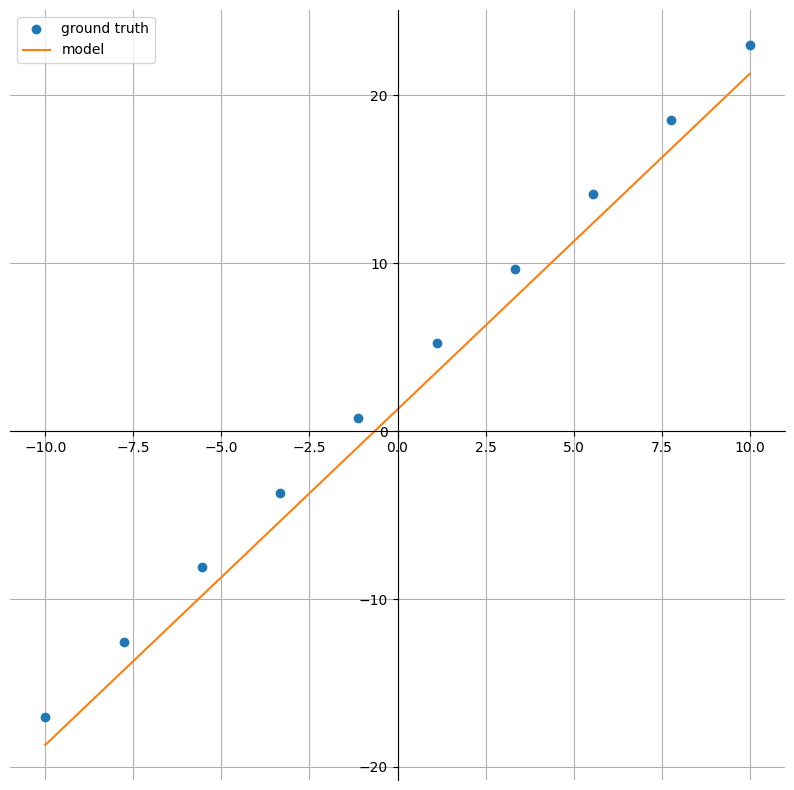

Epoch: 170; Train Loss: 2.803368091583252


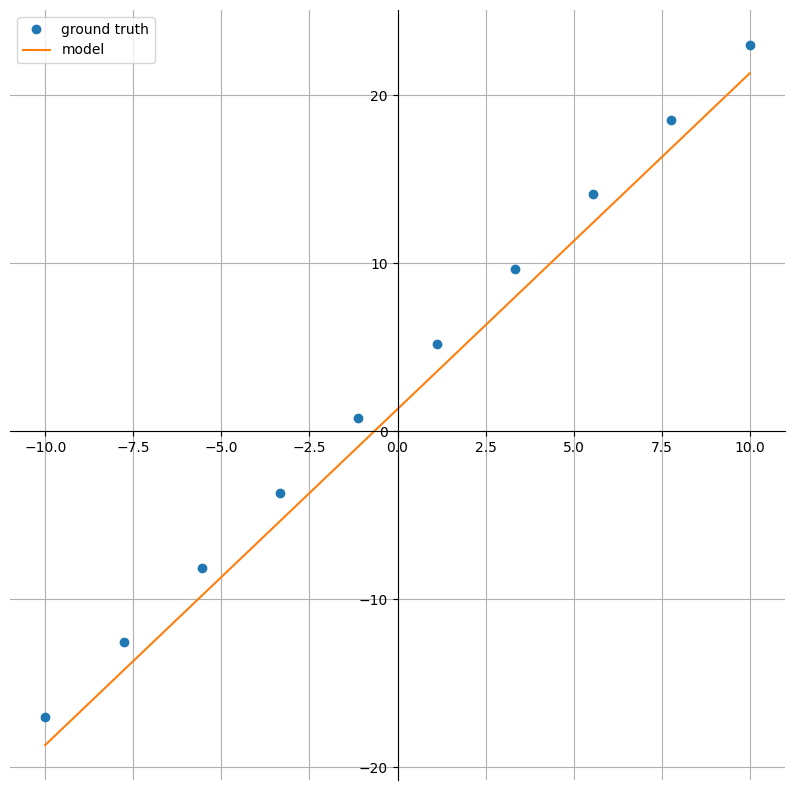

Epoch: 180; Train Loss: 2.693340539932251


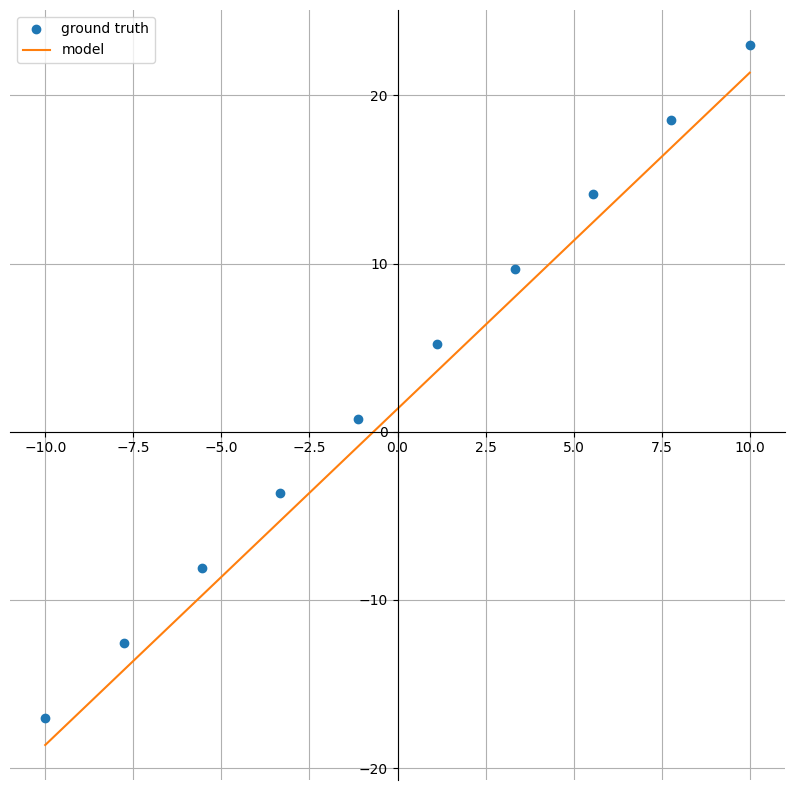

Epoch: 190; Train Loss: 2.587629556655884


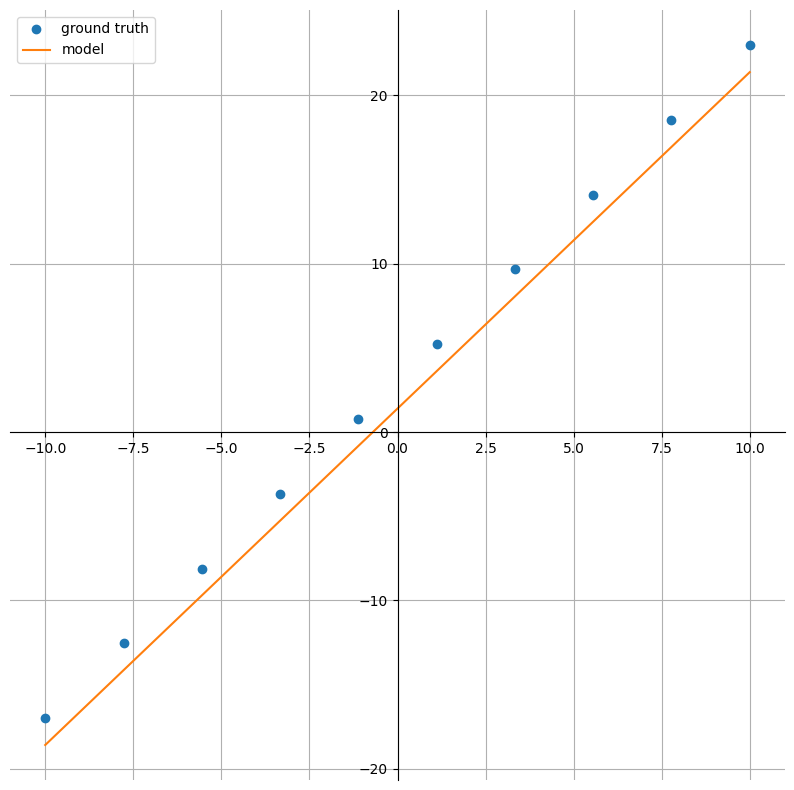

Epoch: 200; Train Loss: 2.4860689640045166


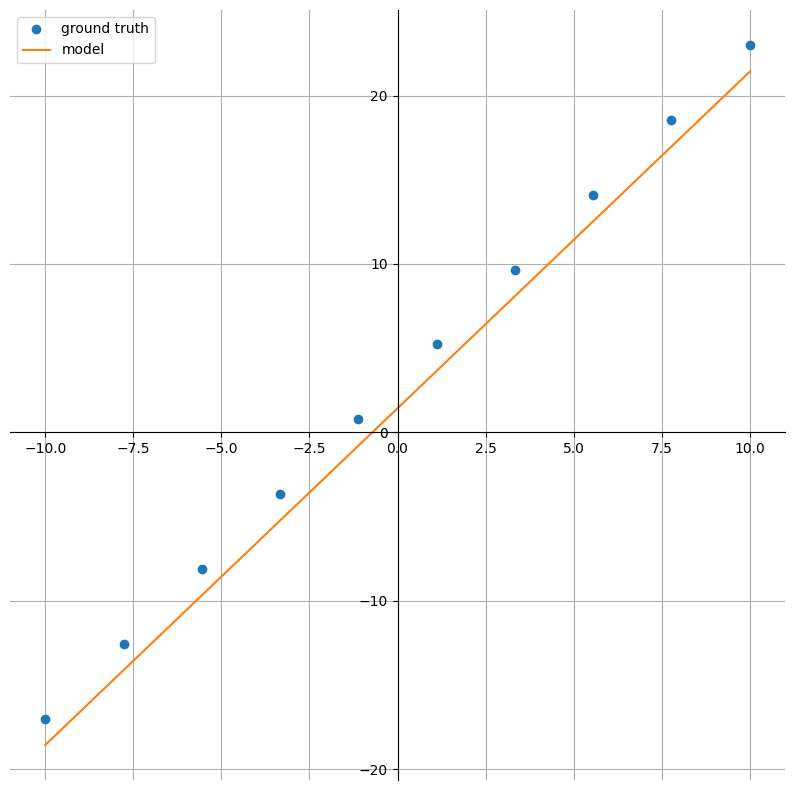

Test Loss: 2.479459285736084


In [21]:
# Definindo quantidade de épocas
epochs = 201
for t in range(epochs):
  train_loss = train(model, train_dataloader, lossfunc, optmizer)
  if t % 10 == 0:
    print(f"Epoch: {t}; Train Loss: {train_loss}")
    plot_comparinson(line, model)

test_loss = test(model, test_dataloader, lossfunc)
print(f"Test Loss: {test_loss}")